In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from nltk.corpus import stopwords

In [2]:
file_path = os.path.join("..","data", "movies_metadata.csv")
df_meta = pd.read_csv(file_path)

# display the first five rows of the DataFrame
df_meta.head()

C:\Users\User\AppData\Local\Temp\ipykernel_27636\3726814497.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(file_path)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# some records have invalid ids, which is why we remove them
df_meta = df_meta.drop([19730, 29503, 35587])

# convert the id to type int and set id as index
df_meta = df_meta.set_index(df_meta['id'].str.strip().replace(',','').astype(int))
pd.set_option('display.max_colwidth', 20)
df_meta.head(2)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
id,,,,,,,,,,,,,,,,,,,,,
862,False,"{'id': 10194, 'n...",30000000,"[{'id': 16, 'nam...",http://toystory....,862,tt0114709,en,Toy Story,"Led by Woody, An...",...,1995-10-30,373554033.0,81.0,[{'iso_639_1': '...,Released,NaN,Toy Story,False,7.7,5415.0
8844,False,NaN,65000000,"[{'id': 12, 'nam...",NaN,8844,tt0113497,en,Jumanji,When siblings Ju...,...,1995-12-15,262797249.0,104.0,[{'iso_639_1': '...,Released,Roll the dice an...,Jumanji,False,6.9,2413.0


In [6]:
file_path = os.path.join("..","data", "credits.csv")
df_credits = pd.read_csv(file_path)
df_credits = df_credits.set_index('id')

In [7]:
# load the movie keywords
file_path = os.path.join("..","data", "keywords.csv")
df_keywords=pd.read_csv(file_path)
df_keywords = df_keywords.set_index('id')

# merge everything into a single dataframe 
df_k_c = df_keywords.merge(df_credits, left_index=True, right_on='id')
df = df_k_c.merge(df_meta[['release_date','genres','overview','title']], left_index=True, right_on='id')
df.head(3)

,keywords,cast,crew,release_date,genres,overview,title
id,,,,,,,
862,"[{'id': 931, 'na...","[{'cast_id': 14,...",[{'credit_id': '...,1995-10-30,"[{'id': 16, 'nam...","Led by Woody, An...",Toy Story
8844,"[{'id': 10090, '...","[{'cast_id': 1, ...",[{'credit_id': '...,1995-12-15,"[{'id': 12, 'nam...",When siblings Ju...,Jumanji
15602,"[{'id': 1495, 'n...","[{'cast_id': 2, ...",[{'credit_id': '...,1995-12-22,"[{'id': 10749, '...",A family wedding...,Grumpier Old Men


In [8]:
# create an empty DataFrame
df_movies = pd.DataFrame()

# extract the keywords
df_movies['keywords'] = df['keywords'].apply(lambda x: [i['name'] for i in eval(x)])
df_movies['keywords'] = df_movies['keywords'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# extract the overview
df_movies['overview'] = df['overview'].fillna('')

# extract the release year 
df_movies['release_date'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

# extract the actors
df_movies['cast'] = df['cast'].apply(lambda x: [i['name'] for i in eval(x)])
df_movies['cast'] = df_movies['cast'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# extract genres
df_movies['genres'] = df['genres'].apply(lambda x: [i['name'] for i in eval(x)])
df_movies['genres'] = df_movies['genres'].apply(lambda x: ' '.join([i.replace(" ", "") for i in x]))

# add the title
df_movies['title'] = df['title']

# merge fields into a tag field
df_movies['tags'] = df_movies['keywords'] + df_movies['cast']+' '+df_movies['genres']+' '+df_movies['release_date']

# drop records with empty tags and duplicates
df_movies.drop(df_movies[df_movies['tags']==''].index, inplace=True)
df_movies.drop_duplicates(inplace=True)

# add a fresh index to the dataframe, which we will later use when refering to items in a vector matrix
df_movies['new_id'] = range(0, len(df_movies))

# Reduce the data to relevant columns
df_movies = df_movies[['new_id', 'title', 'tags']]

# display the data
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.expand_frame_repr', False)
print(df_movies.shape)
df_movies.head(5)

(45432, 3)


,new_id,title,tags
id,,,
862,0,Toy Story,jealousy toy boy friendship friends rivalry boynextdoor newtoy toycomestolifeTomHanks TimAllen DonRickles JimVarney WallaceShawn JohnRatzenberger AnniePotts JohnMorris ErikvonDetten LaurieMetcalf R.LeeErmey SarahFreeman PennJillette Animation Comedy Family 1995
8844,1,Jumanji,boardgame disappearance basedonchildren'sbook newhome recluse giantinsectRobinWilliams JonathanHyde KirstenDunst BradleyPierce BonnieHunt BebeNeuwirth DavidAlanGrier PatriciaClarkson AdamHann-Byrd LauraBellBundy JamesHandy GillianBarber BrandonObray CyrusThiedeke GaryJosephThorup LeonardZola LloydBerry MalcolmStewart AnnabelKershaw DarrylHenriques RobynDriscoll PeterBryant SarahGilson FloricaVlad JuneLion BrendaLockmuller Adventure Fantasy Family 1995
15602,2,Grumpier Old Men,fishing bestfriend duringcreditsstinger oldmenWalterMatthau JackLemmon Ann-Margret SophiaLoren DarylHannah BurgessMeredith KevinPollak Romance Comedy 1995
31357,3,Waiting to Exhale,basedonnovel interracialrelationship singlemother divorce chickflickWhitneyHouston AngelaBassett LorettaDevine LelaRochon GregoryHines DennisHaysbert MichaelBeach MykeltiWilliamson LamontJohnson WesleySnipes Comedy Drama Romance 1995
11862,4,Father of the Bride Part II,baby midlifecrisis confidence aging daughter motherdaughterrelationship pregnancy contraception gynecologistSteveMartin DianeKeaton MartinShort KimberlyWilliams-Paisley GeorgeNewbern KieranCulkin BDWong PeterMichaelGoetz KateMcGregor-Stewart JaneAdams EugeneLevy LoriAlan Comedy 1995


(0.0, 2500.0)

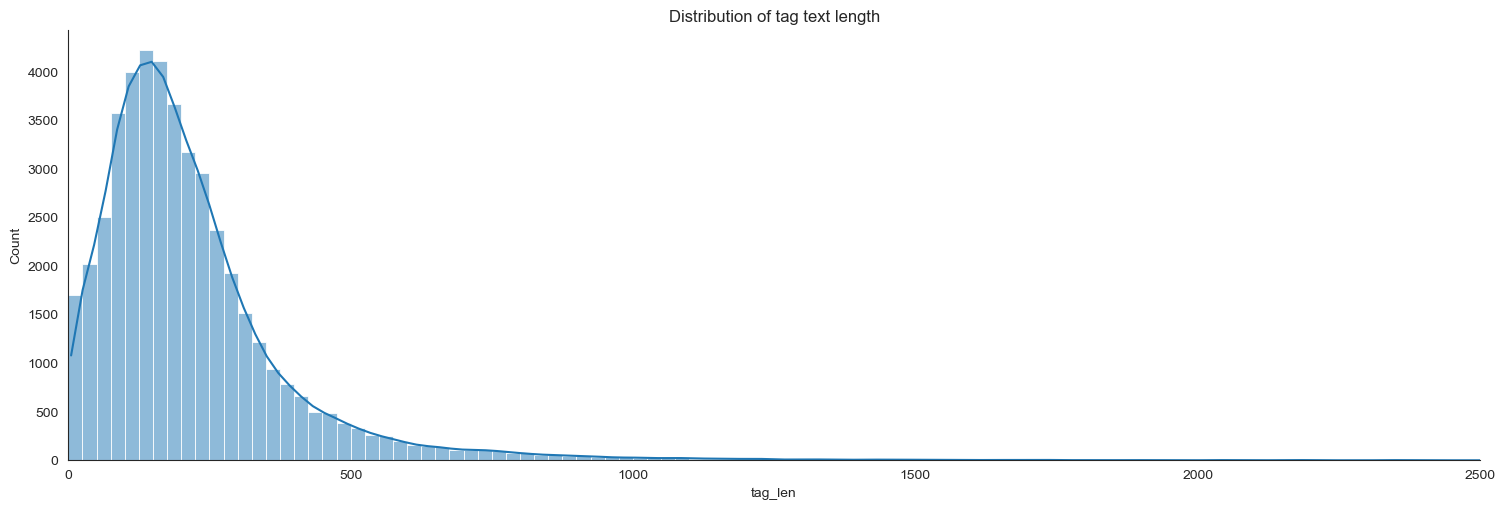

In [9]:
# add the tag length to the movies df
df_movies['tag_len'] = df_movies['tags'].apply(lambda x: len(x))

# illustrate the tag text length
sns.displot(data=df_movies.dropna(), bins=list(range(0, 2000, 25)), height=5, x='tag_len', aspect=3, kde=True)
plt.title('Distribution of tag text length')
plt.xlim([0, 2500])

In [10]:
# set a custom stop list from nltk
stop = list(stopwords.words('english'))

# create the tfid vectorizer, alternatively you can also use countVectorizer
tfidf =  TfidfVectorizer(max_features=5000, analyzer = 'word', stop_words=stop)
vectorized_data = tfidf.fit_transform(df_movies['tags'])
count_matrix = pd.DataFrame(vectorized_data.toarray(), index=df_movies['tags'].index.tolist())
print(count_matrix)



        0     1     2     3     4     5     6     7     8     9     ...  4990  4991  4992  4993  4994  4995  4996  4997  4998  4999
862      0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
8844     0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
15602    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
31357    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
11862    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
439050   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   0.

In [11]:
# print feature names
print(tfidf.get_feature_names_out()[940:990])

['climbing' 'clinteastwood' 'clinthoward' 'clive' 'cliveowen'
 'cliverevill' 'cliverussell' 'clone' 'clorisleachman' 'cloviscornillac'
 'clown' 'clugulager' 'clydekusatsu' 'co' 'coach' 'cobb' 'cocaine' 'code'
 'coffin' 'cohen' 'coldwar' 'cole' 'colehauser' 'coleman' 'colinfarrell'
 'colinfirth' 'colinhanks' 'colinkenny' 'colinsalmon' 'colleencamp'
 'college' 'colmfeore' 'colmmeaney' 'coma' 'combat' 'comedian' 'comedy'
 'comicbook' 'comingofage' 'comingout' 'common' 'communism' 'communist'
 'company' 'competition' 'composer' 'computer' 'con' 'concentrationcamp'
 'concert']


In [12]:
# reduce dimensionality for improved performance
svd = TruncatedSVD(n_components=3000)
reduced_data = svd.fit_transform(count_matrix)

In [13]:
# compute the cosine similarity matrix
similarity = cosine_similarity(reduced_data)
similarity

array([[ 1.00000000e+00,  9.57032808e-02,  6.06050657e-02, ...,
         2.82814724e-03,  0.00000000e+00,  1.56447965e-04],
       [ 9.57032808e-02,  1.00000000e+00,  6.03124845e-02, ...,
        -5.11372132e-03,  0.00000000e+00, -6.19199040e-05],
       [ 6.06050657e-02,  6.03124845e-02,  1.00000000e+00, ...,
         5.73333105e-03,  0.00000000e+00,  1.28183427e-04],
       ...,
       [ 2.82814724e-03, -5.11372132e-03,  5.73333105e-03, ...,
         1.00000000e+00,  0.00000000e+00, -1.80876766e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.56447965e-04, -6.19199040e-05,  1.28183427e-04, ...,
        -1.80876766e-04,  0.00000000e+00,  1.00000000e+00]])

2457 The Matrix


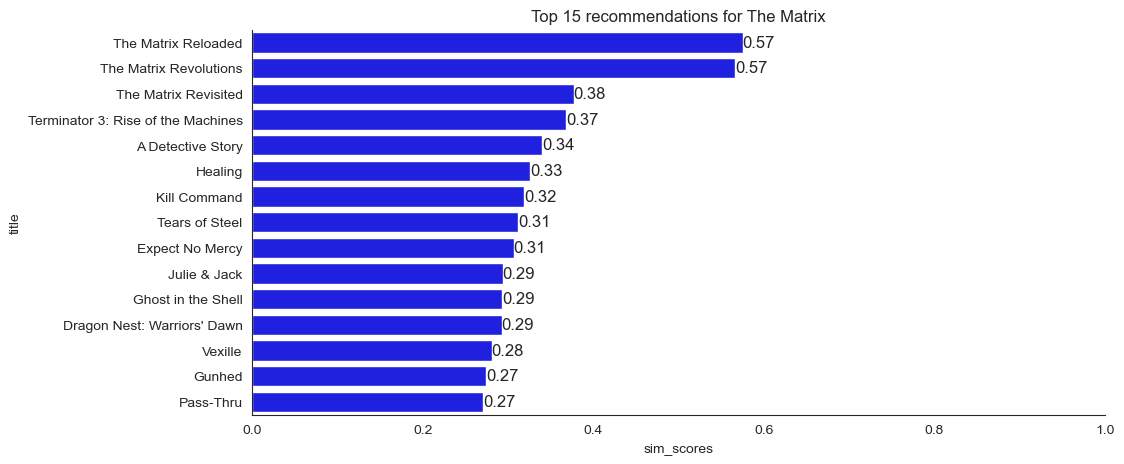

In [14]:
# create a function that takes in movie title as input and returns a list of the most similar movies
def get_recommendations(title, n, cosine_sim=similarity):
    
    # get the index of the movie that matches the title
    movie_index = df_movies[df_movies.title==title].new_id.values[0]
    print(movie_index, title)
    
    # get the pairwsie similarity scores of all movies with that movie and sort the movies based on the similarity scores
    sim_scores_all = sorted(list(enumerate(cosine_sim[movie_index])), key=lambda x: x[1], reverse=True)
    
    # checks if recommendations are limited
    if n > 0:
        sim_scores_all = sim_scores_all[1:n+1]
        
    # get the movie indices of the top similar movies
    movie_indices = [i[0] for i in sim_scores_all]
    scores = [i[1] for i in sim_scores_all]
    
    # return the top n most similar movies from the movies df
    top_titles_df = pd.DataFrame(df_movies.iloc[movie_indices]['title'])
    top_titles_df['sim_scores'] = scores
    top_titles_df['ranking'] = range(1, len(top_titles_df) + 1)
    
    return top_titles_df, sim_scores_all

# generate a list of recommendations for a specific movie title
movie_name = 'The Matrix'
number_of_recommendations = 15
top_titles_df, _ = get_recommendations(movie_name, number_of_recommendations)
 
# visualize the results
def show_results(movie_name, top_titles_df):
    fix, ax = plt.subplots(figsize=(11, 5))
    sns.barplot(data=top_titles_df, y='title', x= 'sim_scores', color='blue')
    plt.xlim((0,1))
    plt.title(f'Top 15 recommendations for {movie_name}')
    pct_values = ['{:.2}'.format(elm) for elm in list(top_titles_df['sim_scores'])]
    ax.bar_label(container=ax.containers[0], labels=pct_values, size=12)

show_results(movie_name, top_titles_df)

In [15]:
# list of movies a user has seen
movie_list = ['The Lion King', 'Seven', 'RoboCop 3', 'Blade Runner', 'Quantum of Solace', 'Casino Royale', 'Skyfall']

# create a copy of the movie dataframe and add a column in which we aggregated the scores
user_scores = pd.DataFrame(df_movies['title'])
user_scores['sim_scores'] = 0.0

# top number of scores to be considered for each movie
number_of_recommendations = 10000
for movie_name in movie_list:
    top_titles_df, _ = get_recommendations(movie_name, number_of_recommendations)
    # aggregate the scores
    user_scores = pd.concat([user_scores, top_titles_df[['title', 'sim_scores']]]).groupby(['title'], as_index=False).sum({'sim_scores'})
# sort and print the aggregated scores
user_scores.sort_values(by='sim_scores', ascending=False)[1:20]

359 The Lion King
38944 Seven
514 RoboCop 3
536 Blade Runner
13057 Quantum of Solace
5657 Casino Royale
19253 Skyfall


,title,sim_scores
41547,Wolf,1.658179
37288,The Three Musketeers,1.378348
3853,Bare Knuckles,1.346330
16723,Journey to the Center of the Earth,1.285738
38960,Total Recall,1.196988
39153,Treasure Island,1.157580
30361,The 39 Steps,1.124494
28600,Spectre,1.073692
248,"20,000 Leagues Under the Sea",1.061565
32051,The Debt,1.051596
